In [29]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

#install
!pip install pyLDAvis

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [30]:
# NLTK Stop words
import nltk; nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
stop_words.extend(['Aufgaben', '(m/w)', "fur", "bitte", "gut", "uber"]) #inclide more stopwords

[nltk_data] Downloading package stopwords to C:\Users\LE HOANG
[nltk_data]     NHAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
#read data
df = pd.read_excel(r"C:\Users\LE HOANG NHAN\Desktop\jobDescriptionData.xlsx")
df['title_description'] = df['title'].str.cat(df['description'],sep=" ")
df.head()

,id,hiringOrganization,group,title,description,employmentType,tags,jobLocation,spider,firstSeen,lastSeen,identifier,filename,title_description
0,297,Margitta Heinecke Existentia Personalvermittlung,Bundesagentur für Arbeit,IT Administrator (m/w) (Informatikkaufmann/-frau),Aufgaben: \n \nSystembetreuung \nImplementi...,Vollzeit; Bei der Besetzung des Stellenangebot...,Job Board,"Dresden, Sachsen, Deutschland",arbeitsagentur,2016-02-14 02:01:45,2016-02-14 02:01:45,10000-1139133361-S,arbeitsagentur_002dc952f9d2e625c6b117f64179eea...,IT Administrator (m/w) (Informatikkaufmann/-fr...
1,655,CNCN - Contract Consulting GmbH,Bundesagentur für Arbeit,Mitarbeiter (m/w) Support-Team (Anwendungssyst...,Wir suchen im Auftrag eines Kunden ab sofort !...,Vollzeit; nach Vereinbarung; Bei der Besetzung...,Job Board,"Nürnberg, Mittelfranken, Bayern, Deutschland; ...",arbeitsagentur,2017-11-19 01:08:47,2017-11-19 01:08:47,12961-217374171118020211-S,arbeitsagentur_0067b024bf6f7d27105744eaf75bd13...,Mitarbeiter (m/w) Support-Team (Anwendungssyst...
2,1569,RADAS Jobbörse & Personalvermittlung GmbH,Bundesagentur für Arbeit,Software-Entwickler / SPS-Programmierer (m/w) ...,RADAS Jobbörse & Personalvermittlung GmbH ist ...,Vollzeit; 40 Wochenstunden; nach Qualifikation...,Job Board,"97080 Würzburg, Bayern, Deutschland",arbeitsagentur,2015-06-07 00:27:23,2015-06-07 00:27:23,12254-1004998-S,arbeitsagentur_00fde52cc06730f1534783aec2a607b...,Software-Entwickler / SPS-Programmierer (m/w) ...
3,2447,M Plan GmbH,Bundesagentur für Arbeit,Software-System-Ingenieur (m/w) Elektromobilit...,M Plan steht für geballte Kompetenz und Erfahr...,Vollzeit; Bei der Besetzung des Stellenangebot...,Job Board,"68161 Mannheim, Baden-Württemberg, Deutschland",arbeitsagentur,2015-06-24 05:39:19,2015-06-24 05:39:19,12266-53947_460345-S,arbeitsagentur_01807213e8d37784dc4d26db4253718...,Software-System-Ingenieur (m/w) Elektromobilit...
4,2825,Brücke Rendsburg-Eckernförde e.V,Bundesagentur für Arbeit,Fachinformatikerin für Systemintegration (w/m)...,Wir stellen zur Verstärkung unseres IT-Teams i...,"Vollzeit, Teilzeit - flexibel; Bei der Besetzu...",Job Board,"Ahlmannstr. 2a, 24768 Rendsburg, Schleswig-Hol...",arbeitsagentur,2017-10-29 01:06:39,2017-10-29 01:06:39,10000-1157595558-S,arbeitsagentur_01bb20a016a0eac6c680b5d55872b11...,Fachinformatikerin für Systemintegration (w/m)...


In [32]:
# Convert to list
data = df.title_description.values.tolist()
#data is a list of texts

# Remove special letters
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

data = [re.sub('[()]', '', sent) for sent in data]

data = [re.sub('[/]', '', sent) for sent in data]

data = [re.sub('[-]', '', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Remove : characters
data = [re.sub(':', ' ', sent) for sent in data]

pprint(data[:1])

['IT Administrator mw Informatikkaufmannfrau Aufgaben  Systembetreuung '
 'Implementierung und Instandsetzung von Hardware Unterstützung im Bereich '
 'Netzwerkadministration User Help Desk Profil  Erfolgreich abgeschlossene '
 'Ausbildung aus dem Bereich Informationstechnik Kenntnisse im Umgang mit '
 'Microsoft Betriebssystemen und Windows Server Kenntnisse im Umgang mit PC '
 'Hardware IT']


In [33]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
# simple_preprocess: Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
data_words = list(sent_to_words(data))

print(data_words[:1])

[['it', 'administrator', 'mw', 'aufgaben', 'systembetreuung', 'implementierung', 'und', 'instandsetzung', 'von', 'hardware', 'unterstutzung', 'im', 'bereich', 'user', 'help', 'desk', 'profil', 'erfolgreich', 'abgeschlossene', 'ausbildung', 'aus', 'dem', 'bereich', 'kenntnisse', 'im', 'umgang', 'mit', 'microsoft', 'und', 'windows', 'server', 'kenntnisse', 'im', 'umgang', 'mit', 'pc', 'hardware', 'it']]


In [34]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):   # lemmatization: achieve the root forms
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [35]:
# Initialize spacy 'de' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download de                                   
nlp = spacy.load('de', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['aufgaben systembetreuung implementierung instandsetzung hardware unterstutzung bereich user erfolgreich abgeschlossen ausbildung bereich kenntnisse umgang microsoft windows server kenntnisse umgang', 'mitarbeiter mw supportteam suchen auftrag kunden sofort aufgaben gehoren selbststandige priorisierung bearbeitung eingehend anfragen losung komplex sachverhalte bedarf zusammenarbeit zustandigen fachbereichen ggf weiterleitung administratoren unterstutzung kunden fachlich fragen betreuung national international kunden technisch fachlich themen peakwork produkten abwicklung jira dokumentation pflegen mitbringen abgeschlossen technische ausbildung fachinformatik mathematisch technisch assistent entsprechend berufserfahrung umgang businesskunden hoch auffassungsgabe ausgepragte teamfahigkeit arbeitsweise soziale kompetenz sehr gutes technisch analytisch logisch verstandnis exzellent sprachliche ausdrucksweise deutschen auch englisch linux kenntnisse vorteil ansprechpartner anhut wichtig bi

In [36]:
# a document word matrix

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word , at least 10 times
                             stop_words=stop_words,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

c:\users\le hoang nhan\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aufgaben', 'ber', 'hrend', 'nnen', 'nnte', 'rde', 'rden'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [37]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")  #percentage of non-zero datapoints in the document-word matrix (data_vectorized)

Sparsicity:  2.840281425891182 %


In [38]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [39]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1224050.4108618612
Perplexity:  1084.9204412846634
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [40]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

c:\users\le hoang nhan\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [41]:
# Best Model
best_lda_model = model.best_estimator_      #model = GridSearchCV

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -454052.9998362435
Model Perplexity:  1035.0338858278694


In [42]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.01,0.01,0.31,0.01,0.01,0.01,0.01,0.01,0.01,0.65,9
Doc1,0,0,0.63,0.34,0,0,0.02,0,0,0,2
Doc2,0,0,0,0,0.67,0,0,0,0.33,0,4
Doc3,0,0.46,0,0.11,0.23,0.09,0,0.1,0,0,1
Doc4,0,0,0.09,0.22,0,0.1,0,0,0,0.58,9
Doc5,0,0,0,0,0,0,0,0.97,0,0,7
Doc6,0.03,0,0,0.47,0,0,0,0,0.06,0.43,3
Doc7,0.14,0,0,0.78,0.07,0,0,0,0,0,3
Doc8,0,0.15,0,0.17,0.05,0,0,0,0,0.62,9
Doc9,0,0,0.33,0,0,0,0,0,0,0.64,9


In [43]:
#show topic distribution
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,9,455
1,5,315
2,3,211
3,6,189
4,1,178
5,0,157
6,2,156
7,7,146
8,8,127
9,4,66


In [44]:
pyLDAvis.enable_notebook()      #https://www.objectorientedsubject.net/2018/08/experiments-on-topic-modeling-pyldavis/
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

c:\users\le hoang nhan\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x          y  topics  cluster       Freq
topic                                                   
9      -66.933388  43.520477       1        1  18.191645
5     -115.512032  18.140282       2        1  15.863999
3      -16.799311  65.672699       3        1  11.957099
1      -68.095787 -80.329269       4        1  10.078806
6      -19.828505   3.564905       5        1   9.746775
7     -115.749977 -42.625175       6        1   9.035379
0       30.616564 -32.796700       7        1   7.615716
2      -65.067474 -18.220150       8        1   6.897573
8      -17.962940 -58.175056       9        1   5.843370
4       30.855091  27.968281      10        1   4.769638, topic_info=     Category         Freq           Term        Total  loglift  logprob
1405  Default  1782.000000         kunden  1782.000000  30.0000  30.0000
2166  Default   434.000000        support   434.000000  29.0000  29.0000
708   Default   833.000000    entwicklung   833.000000  28.0000  28.0000
409   Default  1256.000000      bewerbung  1256.000000  27.0000  27.0000
2165  Default  1491.000000         suchen  1491.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
2220  Topic10    35.227319   technologien   200.721432   1.3028  -5.4686
138   Topic10    45.028594       arbeiten   748.316189   0.2324  -5.2231
3     Topic10    41.163450  abgeschlossen  1123.838545  -0.2641  -5.3129
329   Topic10    41.432089        bereich  1512.734836  -0.5547  -5.3063
2584  Topic10    37.834162  wunschenswert   432.837239   0.6058  -5.3972

[764 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3         1  0.212664  abgeschlossen
3         2  0.160165  abgeschlossen
3         3  0.132581  abgeschlossen
3         4  0.107667  abgeschlossen
3         5  0.043601  abgeschlossen
...     ...       ...            ...
2656      2  0.098159   zuverlassige
2656      3  0.098159   zuverlassige
2656      6  0.073619   zuverlassige
2656      7  0.638034   zuverlassige
2656      8  0.024540   zuverlassige

[2264 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 2, 7, 8, 1, 3, 9, 5])

In [45]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abap,abbau,abbildung,abgeschlossen,abgesichert,abhangig,ablauf,ablaufe,ablaufen,ableitung,...,zuverlassig,zuverlassige,zuverlassigen,zuverlassiger,zuverlassigkeit,zwecke,zweit,zwingen,zwingend,zzgl
Topic0,0.100008,4.126938,0.867497,121.824555,0.100001,0.100015,0.100000,0.100001,0.733221,0.100000,...,2.988818,26.461192,0.100044,8.027335,7.260008,1.115193,0.100006,0.401572,0.100018,3.711019
Topic1,21.606443,0.100004,0.100000,125.973414,5.474109,0.100001,0.100000,0.100016,1.732308,4.399505,...,0.100006,0.100012,6.738190,0.100021,2.691676,0.100000,0.100004,1.253978,0.100021,0.100008
Topic2,0.100009,4.653907,0.100001,95.030375,0.100000,0.100028,0.100001,0.100000,2.066660,0.100003,...,1.415569,0.902363,2.616236,0.100110,15.708507,0.100000,0.100001,12.483098,0.100002,0.100025
Topic3,0.879698,0.100004,0.100047,147.956903,0.100011,0.100006,0.100007,5.457416,6.888095,0.100051,...,0.515493,3.580271,6.945386,5.172470,6.564262,0.100009,0.100033,0.473162,0.100026,0.100028
Topic4,8.159919,0.100001,0.100026,42.414447,0.100007,0.100004,0.100002,0.105006,2.052823,0.100031,...,1.110825,0.100026,0.100000,0.100004,5.568290,0.100001,0.100003,0.100261,0.100005,4.138973


In [46]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,kunden,bewerbung,suchen,aufgaben,freuen,gerne,stehen,verfugung,abgeschlossen,bereich,kenntnisse,bieten,erfahrung,email,ausbildung
Topic 1,kunden,entwicklung,gelten,kenntnisse,aufgaben,entwickeln,weit,freuen,gerne,bereich,erfahrung,spannend,bewerbung,kennziffer,ferchau
Topic 2,kunden,support,kenntnisse,suchen,aufgaben,telefonisch,ansprechpartner,auftrag,bewerbung,mitarbeiter,mail,freuen,abgeschlossen,hard,bearbeitung
Topic 3,aufgaben,kenntnisse,bereich,suchen,hoch,erfahrung,umsetzung,bieten,abgeschlossen,zusammenarbeit,arbeiten,team,entwicklung,neu,planung
Topic 4,konnen,bewerbung,senden,erfahrung,kenntnisse,daten,entwicklung,html,aufgaben,informatik,kunden,ipser,profil,folgend,unternehmen
Topic 5,kenntnisse,eignung,bewerbung,offentlichen,menschen,insbesondere,abgeschlossen,tvod,frauen,stadt,aufgaben,berucksichtigt,gleich,bereitschaft,bewerbungen
Topic 6,hochschule,universitat,forschung,frauen,bewerbungen,erscheinen,stelle,besetzen,bewerbung,professur,lehre,erwarten,eignung,bevorzugen,bereich
Topic 7,bieten,software,kenntnisse,entwicklung,projekte,bereich,international,informatik,erfolgreich,studium,profil,erfahrungen,unternehmen,brunel,rund
Topic 8,suchen,email,bewerbung,freuen,kunden,unternehmen,konnen,bewerbungen,aufgaben,ausbildung,telefonisch,kenntnisse,profil,unterlagen,munchen
Topic 9,kenntnisse,kunden,bereich,suchen,unternehmen,team,aufgaben,erfahrung,freuen,bieten,abgeschlossen,server,arbeiten,ausbildung,bewerbung


In [47]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=10, random_state=100).fit_predict(lda_output)
#The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent
#parts in order to make certain subsequent matrix calculations simpler. https://machinelearningmastery.com/singular-value-decomposition-for-machine-learning/ The singular value decomposition (SVD) provides another way to factorize a matrix, into singular vectors and singular values.
# Build the Singular Value Decomposition(SVD) model            
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 10 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.17  0.19  0.19  0.31  0.06  0.33  0.16  0.18  0.12  0.79]
 [-0.04 -0.07 -0.06  0.08 -0.    0.85  0.31 -0.05  0.   -0.4 ]]
Perc of Variance Explained: 
 [0.06 0.21]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

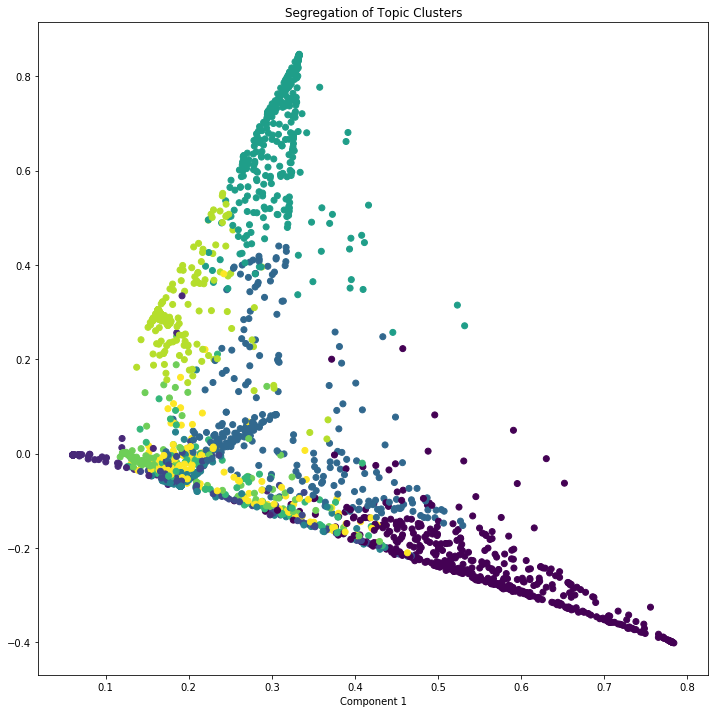

In [48]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )